In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import joypy


In [314]:
file_path = '../data/processed/nba_points_2024_2025.xlsx'
df = pd.read_excel(file_path, usecols="A:T")

# Remove whitespace
df['Home'] = df['Home'].str.strip()
df['Away'] = df['Away'].str.strip()
df['Crew Chief'] = df['Crew Chief'].str.strip()


# Feature engineering
df['Home Win'] = (df['Home Points'] > df['Away Points']).astype(int)
df['Away Win'] = (df['Away Points'] > df['Home Points']).astype(int)

# Assume df is your original DataFrame with a 'Date' column and 'Home' and 'Away' columns
df['Date'] = pd.to_datetime(df['Date'])
# Build a dictionary mapping each team to the set of dates they've played.
teams = pd.concat([df['Home'], df['Away']]).unique()
team_dates = {}
for team in teams:
    # Get all games (dates) where the team appears as home or away.
    team_games = df[(df['Home'] == team) | (df['Away'] == team)]
    # Use dt.date to focus on the date part only.
    team_dates[team] = set(team_games['Date'].dt.date)
# Helper function to check if a team played on the day before the current date.
def played_yesterday(team, current_date):
    # Subtract one day from the current date and compare as a date.
    previous_date = (current_date - pd.Timedelta(days=1)).date()
    return previous_date in team_dates.get(team, set())
# Create new columns using apply:
df['Away BackToBack'] = df.apply(lambda row: played_yesterday(row['Away'], row['Date']), axis=1)
df['Home BackToBack'] = df.apply(lambda row: played_yesterday(row['Home'], row['Date']), axis=1)
df['Either BackToBack'] = df['Away BackToBack'] | df['Home BackToBack']
df['Both BackToBack'] = df['Away BackToBack'] & df['Home BackToBack']

In [315]:
print('Away BackToBacks: ', df['Away BackToBack'].sum(), " | " ,round(df['Away BackToBack'].mean() * 100), '%')
print('Home BackToBacks: ', df['Home BackToBack'].sum(), " | " ,round(df['Home BackToBack'].mean() * 100), '%')
print('Either BackToBacks: ', df['Either BackToBack'].sum(), " | " ,round(df['Either BackToBack'].mean() * 100), '%')
print('Both BackToBacks: ', df['Both BackToBack'].sum(), " | " ,round(df['Both BackToBack'].mean() * 100), '%')

Away BackToBacks:  177  |  19 %
Home BackToBacks:  169  |  18 %
Either BackToBacks:  292  |  31 %
Both BackToBacks:  54  |  6 %


In [316]:
df.columns

Index(['Date', 'Weekday', 'Away', 'Home', 'NBA Cup Game', 'Crew Chief',
       'Referee', 'Umpire', 'Open Total', 'Open Home Spread', 'Away Points',
       'Home Points', 'Actual Total', 'Actual Home Spread', 'Game Count',
       'Over', 'Over Amount', 'Under', 'Under Amount', 'Push', 'Home Win',
       'Away Win', 'Away BackToBack', 'Home BackToBack', 'Either BackToBack',
       'Both BackToBack'],
      dtype='object')

In [317]:
print('Games Tracked: ', round(df['Game Count'].sum()))
print('Average Open Total: ', round(df['Open Total'].mean(), 2))
print('Average Actual Total: ', round(df['Actual Total'].mean(), 2))
print('Over Percent: ', round(df['Over'].mean() * 100, 2))
print('Under Percent: ', round(df['Under'].mean() * 100, 2))
print('First Date Tracked: ', df[df['Game Count'] == 1]['Date'].dt.strftime('%Y-%m-%d').min())
print('Last Date Tracked: ', df[df['Game Count'] == 1]['Date'].dt.strftime('%Y-%m-%d').max())

Games Tracked:  937
Average Open Total:  225.92
Average Actual Total:  226.71
Over Percent:  52.45
Under Percent:  47.13
First Date Tracked:  2024-10-22
Last Date Tracked:  2025-03-07


In [318]:
# Get all unique team names from both Home and Away columns
teams = pd.concat([df['Home'], df['Away']]).unique()

# Initialize a list to store the stats for each team
stats = []

for team in teams:
    # Overall: games where the team is either home or away
    team_games = df[(df['Home'] == team) | (df['Away'] == team)]
    overall_over_pct = team_games['Over'].mean() * 100  # Proportion of games with Over
    
    # Home games only
    home_games = df[df['Home'] == team]
    home_over_pct = home_games['Over'].mean() * 100 if not home_games.empty else None
    
    # Away games only
    away_games = df[df['Away'] == team]
    away_over_pct = away_games['Over'].mean() * 100 if not away_games.empty else None
    
    stats.append({
        'Team': team,
        'Overall Over %': overall_over_pct,
        'Home Over %': home_over_pct,
        'Away Over %': away_over_pct
    })

# Convert the list of stats into a DataFrame
stats_df = pd.DataFrame(stats)

In [319]:
# teams with highest over percentage
print('Teams with the Most Overs:')
print('-' * 50)
print(stats_df.sort_values('Overall Over %', ascending=False).head(round(30*.25))) # top 25%

Teams with the Most Overs:
--------------------------------------------------
   Team  Overall Over %  Home Over %  Away Over %
23  MEM       67.741935    62.500000    73.333333
17  CLE       61.290323    60.606061    62.068966
5   ATL       60.317460    66.666667    54.545455
14  DEN       60.317460    67.741935    53.125000
9   UTA       59.375000    54.545455    64.516129
3   PHI       58.064516    53.125000    63.333333
2   DET       57.142857    54.838710    59.375000
7   NOP       56.451613    53.125000    60.000000


In [320]:
# teams with highest over percentage
print('Teams with the Most Unders:')
print('-' * 50)
print(stats_df.sort_values('Overall Over %', ascending=True).head(round(30*.25))) # top 25%

Teams with the Most Unders:
--------------------------------------------------
   Team  Overall Over %  Home Over %  Away Over %
20  CHA       38.709677    36.363636    41.379310
16  ORL       42.424242    35.294118    50.000000
27  BKN       44.262295    41.379310    46.875000
29  GSW       44.444444    36.666667    51.515152
11  LAC       46.031746    45.161290    46.875000
0   BOS       46.031746    53.125000    38.709677
13  DAL       48.437500    36.363636    61.290323
1   LAL       49.180328    50.000000    48.275862


In [321]:
# Ensure the 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'])
# get only played games
df_played = df[df['Game Count'] == 1]

# Get all unique team names from both Home and Away columns
teams = pd.concat([df_played['Home'], df_played['Away']]).unique()

# List to hold stats for each team
stats = []

for team in teams:
    # Overall games for the team (as home or away)
    team_games = df_played[(df_played['Home'] == team) | (df_played['Away'] == team)]
    team_games_last10 = team_games.sort_values('Date').tail(10)
    
    # Home games for the team
    home_games = df_played[df_played['Home'] == team]
    home_games_last10 = home_games.sort_values('Date').tail(10)
    
    # Away games for the team
    away_games = df_played[df_played['Away'] == team]
    away_games_last10 = away_games.sort_values('Date').tail(10)
    
    # Calculate Over % for each subset
    overall_over_pct = team_games_last10['Over'].mean() * 100 if not team_games_last10.empty else None
    home_over_pct = home_games_last10['Over'].mean() * 100 if not home_games_last10.empty else None
    away_over_pct = away_games_last10['Over'].mean() * 100 if not away_games_last10.empty else None

    # Calculate scoring averages
    # For overall games, pick the appropriate points column based on whether the team was home or away.
    def get_team_points(row):
        return row['Home Points'] if row['Home'] == team else row['Away Points']
    
    if not team_games_last10.empty:
        overall_team_points = team_games_last10.apply(get_team_points, axis=1)
        overall_avg_points = overall_team_points.mean()
    else:
        overall_avg_points = None

    home_avg_points = home_games_last10['Home Points'].mean() if not home_games_last10.empty else None
    away_avg_points = away_games_last10['Away Points'].mean() if not away_games_last10.empty else None
    overall_avg_total = team_games_last10['Actual Total'].mean()
    overall_avg_open_total = team_games_last10['Open Total'].mean()
    
    stats.append({
        'Team': team,
        'Overall Over %': overall_over_pct,
        'Overall Avg Points': overall_avg_points,
        'Overall Avg Total': overall_avg_total
    })

# Convert the list of stats into a DataFrame and display
stats10_df = pd.DataFrame(stats)

In [322]:
print('Teams with the most Overs in their last 10 games:')
print('-'*70)
print(stats10_df.sort_values(by='Overall Over %',ascending=False).head())

Teams with the most Overs in their last 10 games:
----------------------------------------------------------------------
   Team  Overall Over %  Overall Avg Points  Overall Avg Total
9   UTA            70.0               113.5              235.3
17  CLE            70.0               125.9              236.0
5   ATL            70.0               121.4              245.8
28  OKC            70.0               126.3              243.2
10  POR            60.0               118.3              231.8


In [323]:
# Group by 'Crew Chief' and calculate required stats
crew_stats = df.groupby('Crew Chief').agg(
    games_count=('Crew Chief', 'size'), # total number of games for each crew chief
    over_count=('Over', lambda x: x.sum()),
    under_count=('Under', lambda x: x.sum())
).reset_index()

# Calculate over percentage
crew_stats['over_percentage'] = (crew_stats['over_count'] / crew_stats['games_count']) * 100
crew_stats['under_percentage'] = (crew_stats['under_count'] / crew_stats['games_count']) * 100

In [324]:
print('\n', 'Crew Chiefs with the most OVERS\n', ('-')*50 )
print(round(crew_stats[crew_stats['games_count']>=30][['Crew Chief',
                                                 'games_count',
                                                 'over_percentage']].sort_values(by='over_percentage',
                                                                                 ascending=False),2).head())
print('\n', 'Crew Chiefs with the most UNDERS\n', ('-')*50 )
print(round(crew_stats[crew_stats['games_count']>=30][['Crew Chief',
                                                 'games_count',
                                                 'over_percentage']].sort_values(by='over_percentage',
                                                                                 ascending=False),2).head())


 Crew Chiefs with the most OVERS
 --------------------------------------------------
        Crew Chief  games_count  over_percentage
24    Scott Foster           43            65.12
28      Tyler Ford           52            63.46
13      Josh Tiven           50            62.00
18      Marc Davis           47            59.57
20  Mitchell Ervin           35            57.14

 Crew Chiefs with the most UNDERS
 --------------------------------------------------
        Crew Chief  games_count  over_percentage
24    Scott Foster           43            65.12
28      Tyler Ford           52            63.46
13      Josh Tiven           50            62.00
18      Marc Davis           47            59.57
20  Mitchell Ervin           35            57.14


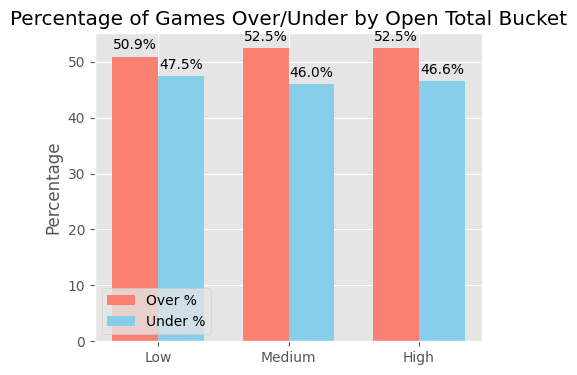

In [325]:
df['Open Total Bucket'] = pd.qcut(df['Open Total'], q=3, labels=['Low', 'Medium', 'High'])

# Group by bucket and compute counts
bucket_stats = df.groupby('Open Total Bucket', observed=True).agg(
    total_games=('Open Total', 'count'),
    over_count=('Over', 'sum'),    # True counts as 1, so sum gives number of overs.
    under_count=('Under', 'sum')  # Same for under.
).reset_index()

# Compute percentages for each bucket.
bucket_stats['Over %'] = (bucket_stats['over_count'] / bucket_stats['total_games']) * 100
bucket_stats['Under %'] = (bucket_stats['under_count'] / bucket_stats['total_games']) * 100

# Visualization using matplotlib with ggplot style.
plt.style.use('ggplot')

labels = bucket_stats['Open Total Bucket']
over_pct = bucket_stats['Over %']
under_pct = bucket_stats['Under %']

x = np.arange(len(labels))
width = 0.35  # Width for each bar

fig, ax = plt.subplots(figsize=(5, 4))

# Create grouped bar chart: one bar for Over % and one for Under % for each bucket.
rects1 = ax.bar(x - width/2, over_pct, width, label='Over %', color='salmon')
rects2 = ax.bar(x + width/2, under_pct, width, label='Under %', color='skyblue')

ax.set_ylabel('Percentage')
ax.set_title('Percentage of Games Over/Under by Open Total Bucket')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally, add data labels above each bar
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text a bit above the bar
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.show()

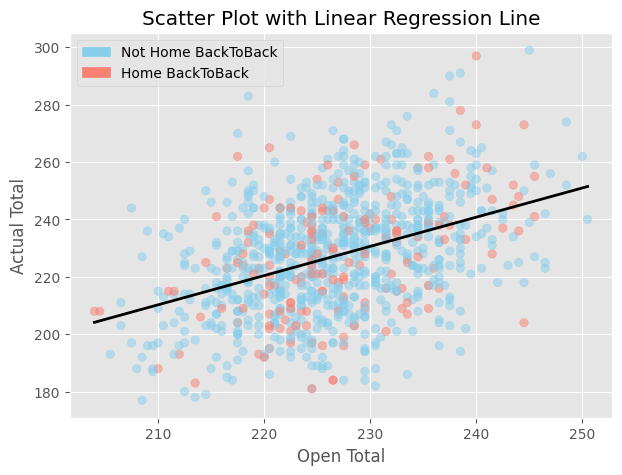

In [326]:
# Assume df is your DataFrame with 'Open Total' and 'Actual Total' columns
df_played = df[df['Game Count'] == 1]
x = df_played['Open Total']
y = df_played['Actual Total']

# Calculate the linear regression coefficients (slope and intercept)
slope, intercept = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept

# Set the ggplot style
plt.style.use('ggplot')
plt.figure(figsize=(7, 5))

# Define a discrete colormap for boolean values:
# For example, 0 (False) will be 'skyblue' and 1 (True) will be 'salmon'
cmap = ListedColormap(['skyblue', 'salmon'])

# Convert the boolean 'Home BackToBack' column to integers: 0 for False, 1 for True
colors = df_played['Home BackToBack'].astype(int)

# Create scatter plot with the discrete colormap
plt.scatter(x, y, alpha=0.5, c=colors, cmap=cmap)

# Plot the regression line
plt.plot(x_line, y_line, color='black', linewidth=2)

plt.xlabel('Open Total')
plt.ylabel('Actual Total')
plt.title('Scatter Plot with Linear Regression Line')

# Create custom legend patches for the two categories
patch_false = mpatches.Patch(color='skyblue', label='Not Home BackToBack')
patch_true = mpatches.Patch(color='salmon', label='Home BackToBack')
plt.legend(handles=[patch_false, patch_true])

plt.show()